In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#!cp /content/drive/MyDrive/6888/as22/fruits-360_dataset.zip /content
#!unzip /content/fruits-360_dataset.zip

!pip install datasets
!pip install transformers
!pip install accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 108.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 7.0 MB/s eta 0:00:00


# Problem 1

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



base_path = '/content/fruits-360_dataset/fruits-360'
train_path = base_path + '/Training'
test_path = base_path + '/Test'


BATCH_SIZE = 1000
IMG_SIZE = (75, 75)
SEED = 42


In [ ]:
train_gen, valid_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_gen = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


# use cache to improve speed
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Found 67692 files belonging to 131 classes.
Using 57539 files for training.
Using 10153 files for validation.
Found 22688 files belonging to 131 classes.


In [ ]:
from tensorflow.keras.applications import ResNet101, InceptionV3, EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
import time
import matplotlib.pyplot as plt


def create_and_train_model(base_model, train_gen, test_gen):

    # Freeze layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add Flatten layer
    x = Flatten()(base_model.output)

    # Modify pre-trained model
    output = Dense(131, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model for 50 epochs
    history = model.fit(train_gen, validation_data=valid_gen, epochs=50)


    # Plotting Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Measure inference time
    start_time = time.time()
    _, accuracy = model.evaluate(test_gen)
    end_time = time.time()
    inference_time = end_time - start_time

    # Get model size (number of parameters)
    num_params = model.count_params()

    return num_params, inference_time, accuracy


## ResNet101

Epoch 1/50
58/58 [==============================] - 16s 175ms/step - loss: 1.0383 - accuracy: 0.8777 - val_loss: 0.0092 - val_accuracy: 0.9973
Epoch 2/50
58/58 [==============================] - 8s 141ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0039 - val_accuracy: 0.9991
Epoch 3/50
58/58 [==============================] - 8s 141ms/step - loss: 2.3212e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 0.9995
Epoch 4/50
58/58 [==============================] - 8s 142ms/step - loss: 1.5769e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 0.9995
Epoch 5/50
58/58 [==============================] - 8s 142ms/step - loss: 1.2384e-04 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 0.9995
Epoch 6/50
58/58 [==============================] - 8s 141ms/step - loss: 1.0525e-04 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 0.9996
Epoch 7/50
58/58 [==============================] - 8s 142ms/step - loss: 9.1643e-05 - accuracy: 1.0000 - val_loss: 0.0028 - val_ac

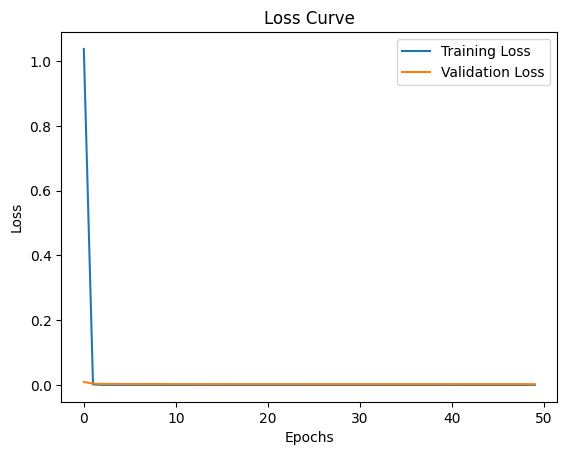

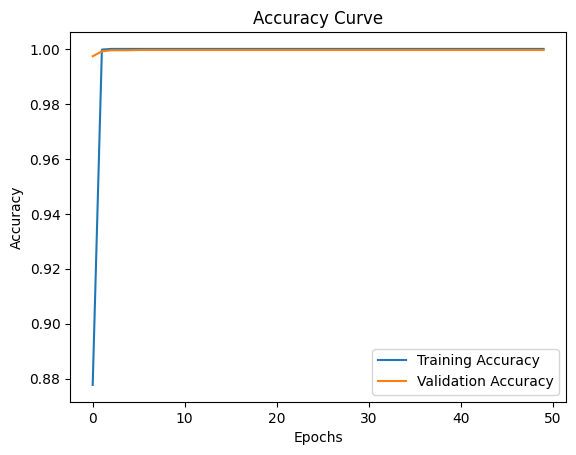

23/23 [==============================] - 3s 123ms/step - loss: 0.3040 - accuracy: 0.9551
ResNet101: Params=45072899, Time=3.25288462638855, Accuracy=0.9550864100456238


In [ ]:
# Create and train ResNet101
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
resnet_params, resnet_time, resnet_acc = create_and_train_model(resnet_base, train_gen, test_gen)
print(f"ResNet101: Params={resnet_params}, Time={resnet_time}, Accuracy={resnet_acc}")



## InceptionV3

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/50
58/58 [==============================] - 12s 92ms/step - loss: 28.8679 - accuracy: 0.3771 - val_loss: 5.1887 - val_accuracy: 0.6873
Epoch 2/50
58/58 [==============================] - 3s 48ms/step - loss: 2.9441 - accuracy: 0.7803 - val_loss: 1.6195 - val_accuracy: 0.8350
Epoch 3/50
58/58 [==============================] - 3s 48ms/step - loss: 1.0152 - accuracy: 0.8802 - val_loss: 0.7764 - val_accuracy: 0.8922
Epoch 4/50
58/58 [==============================] - 3s 48ms/step - loss: 0.5639 - accuracy: 0.9180 - val_loss: 0.5188 - val_accuracy: 0.9190
Epoch 5/50
58/58 [==============================] - 3s 48ms/step - loss: 0.3353 - accuracy: 0.9447 - val_loss: 0.3980 - val_accuracy: 0.9365
Epoch 6/50
58/58 [==============================] - 3s 48ms/step - loss: 0.2221 - accuracy: 0.9587 - val_loss: 0.3108 - val_accuracy: 0.9476
Epoch 7/50
58/58 [==============================] - 3s 48ms/step - loss: 0.1622 - accur

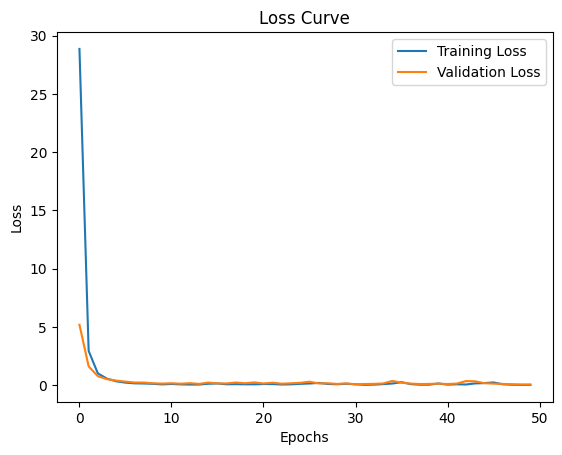

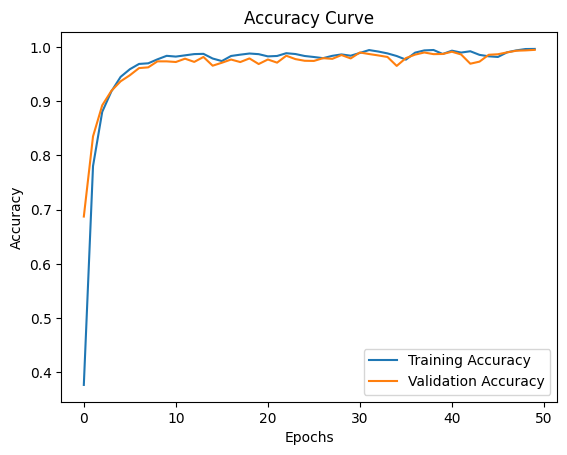

23/23 [==============================] - 2s 76ms/step - loss: 7.0694 - accuracy: 0.7851
InceptionV3: Params=22071203, Time=1.7327241897583008, Accuracy=0.7851287126541138


In [ ]:
# Create and train InceptionV3
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
inception_params, inception_time, inception_acc = create_and_train_model(inception_base, train_gen, test_gen)
print(f"InceptionV3: Params={inception_params}, Time={inception_time}, Accuracy={inception_acc}")


## EfficientNetB1

27018416/27018416 [==============================] - 2s 0us/step
Epoch 1/50
58/58 [==============================] - 18s 132ms/step - loss: 0.5713 - accuracy: 0.8776 - val_loss: 0.0406 - val_accuracy: 0.9971
Epoch 2/50
58/58 [==============================] - 6s 95ms/step - loss: 0.0462 - accuracy: 0.9940 - val_loss: 0.0172 - val_accuracy: 0.9992
Epoch 3/50
58/58 [==============================] - 6s 96ms/step - loss: 0.0259 - accuracy: 0.9976 - val_loss: 0.0107 - val_accuracy: 0.9997
Epoch 4/50
58/58 [==============================] - 5s 95ms/step - loss: 0.0180 - accuracy: 0.9986 - val_loss: 0.0080 - val_accuracy: 0.9997
Epoch 5/50
58/58 [==============================] - 6s 96ms/step - loss: 0.0137 - accuracy: 0.9989 - val_loss: 0.0060 - val_accuracy: 0.9999
Epoch 6/50
58/58 [==============================] - 6s 96ms/step - loss: 0.0105 - accuracy: 0.9993 - val_loss: 0.0048 - val_accuracy: 0.9999
Epoch 7/50
58/58 [==============================] - 6s 95ms/step - loss: 0.0081 - accur

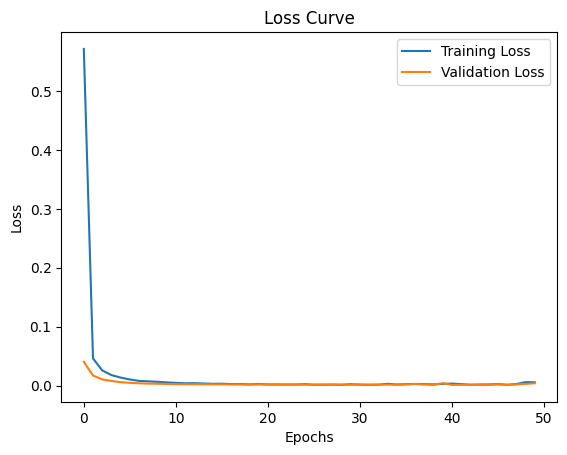

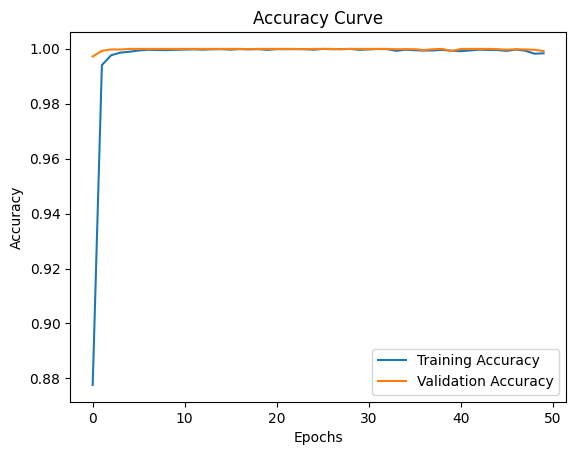

23/23 [==============================] - 2s 81ms/step - loss: 0.1458 - accuracy: 0.9649
EfficientNetB1: Params=8084490, Time=1.8686602115631104, Accuracy=0.9648712873458862


In [ ]:
# Create and train EfficientNetB1
effnet_base = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
effnet_params, effnet_time, effnet_acc = create_and_train_model(effnet_base, train_gen, test_gen)
print(f"EfficientNetB1: Params={effnet_params}, Time={effnet_time}, Accuracy={effnet_acc}")

## Discussion

| Model | Dropout rate | Test accuracy |
| --- | --- | --- |
| 1 | 0.1 | 96.7% |
| 1 | 0.3 | 81.2% |
| 1 | 0.5 | 75.2% |
| 2 | 0.3 | 82.1% |

# Problem 2

In [89]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")
raw_train_dataset = raw_datasets['train'].train_test_split(test_size=1000)
train_dataset = raw_train_dataset['train']
val_dataset = raw_train_dataset['test']
test_dataset = raw_datasets['test']



In [90]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

def tokenize_batch(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_data = train_dataset.map(tokenize_batch, batched=True)
val_data = val_dataset.map(tokenize_batch, batched=True)
test_data = test_dataset.map(tokenize_batch, batched=True)

train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])



Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

In [91]:
from transformers import AlbertForSequenceClassification

model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.247200,0.182516,0.925000
2,0.173000,0.213101,0.937000
3,0.122800,0.284125,0.938000
4,0.076700,0.352288,0.930000
5,0.040400,0.369072,0.935000
6,0.022800,0.442082,0.943000
7,0.012400,0.514923,0.935000
8,0.006100,0.560036,0.936000
9,0.001900,0.621329,0.933000
10,0.000800,0.592462,0.933000


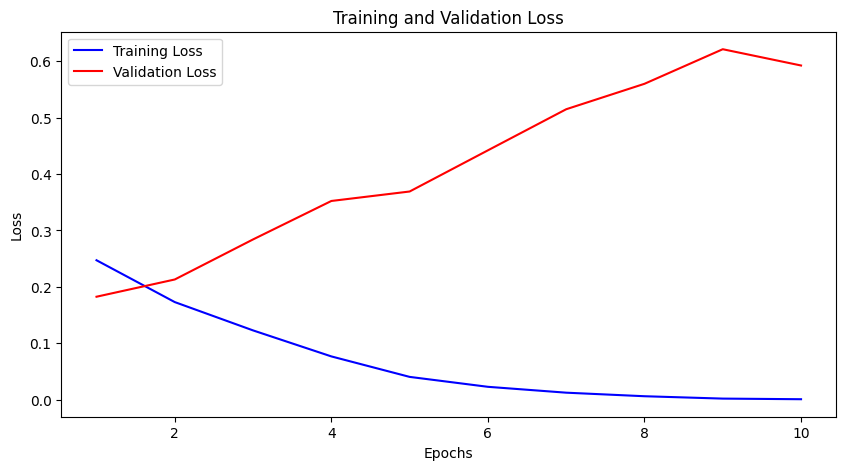

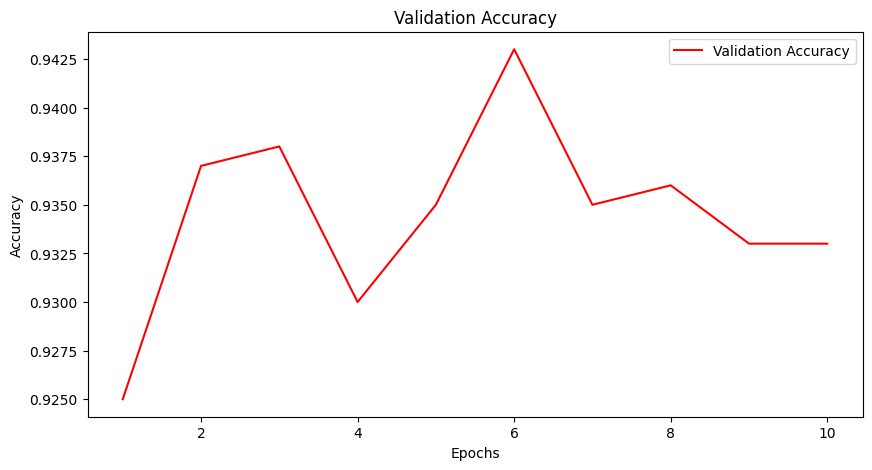

Test Accuracy: 0.93772


In [92]:
from transformers import Trainer, TrainingArguments
from transformers import TrainerCallback
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_score(labels, predictions)}


class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []
        self.validation_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.training_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.validation_losses.append(logs['eval_loss'])
        if 'eval_accuracy' in logs:
            self.validation_accuracies.append(logs['eval_accuracy'])


metrics_callback = MetricsCallback()

training_args = TrainingArguments(
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    learning_rate=1e-5,
    weight_decay=0.01,
    num_train_epochs=10,
    output_dir='./results'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    callbacks=[metrics_callback],
    compute_metrics=compute_metrics
)

trainer.train()

training_loss = metrics_callback.training_losses
validation_loss = metrics_callback.validation_losses
validation_accuracy = metrics_callback.validation_accuracies

# Assuming that logs are saved every epoch, use this for x-axis
epochs = list(range(1, len(training_loss) + 1))

import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss', color='blue')
plt.plot(epochs, validation_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', color='red')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Test the model
evaluation_results = trainer.evaluate(eval_dataset=test_data)
print(f"Test Accuracy: {evaluation_results['eval_accuracy']}")




In [93]:
import torch

text = "This movie was really amazing!"
tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

# Move tokens to the same device as the model
tokens = {key: val.to('cuda') for key, val in tokens.items()}

with torch.no_grad():  # Deactivate gradients for the following code
    outputs = model(**tokens)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    label = torch.argmax(probabilities).item()
    class_probability = probabilities[0][label].item()

# Output the results
print(f"Probabilities: {probabilities.cpu().numpy()}")  # Move tensor to CPU to convert to numpy
if label == 1:
    print(f"Prediction: Positive, Probability: {class_probability}")
else:
    print(f"Prediction: Negative, Probability: {class_probability}")


Probabilities: [[4.4176218e-04 9.9955827e-01]]
Prediction: Positive, Probability: 0.9995582699775696
